<a href="https://www.kaggle.com/code/fummicc1/fummicc1-cassava?scriptVersionId=115383373" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Data

In [47]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import pandas as pd
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, List, Tuple
from tqdm import tqdm
import pandas as pd

In [48]:
import timm

timm.list_models("efficient*", pretrained=True)

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t']

In [49]:
def class2dict(f) -> Dict:
    ans = dict()
    for name in dir(f):
        if name.startswith("__"):
            continue
        if not _is_primitive(getattr(f, name)):
            ans[name] = class2dict(getattr(f, name))
        else:
            ans[name] = getattr(f, name)
    return ans


def _is_primitive(value) -> bool:
    primitive = (int, str, bool, float, List, Dict)
    return type(value) in primitive

## Config

In [50]:
from modules.config import Config

config = Config()
config.n_epochs = 10
config.batch_size = 128
config.num_workers = 8
config.lr = 1e-5
config.model_name = "efficientnet_b4"
config.is_kaggle_notebook = False

print(config.base_input_path)

./


<AxesSubplot: >

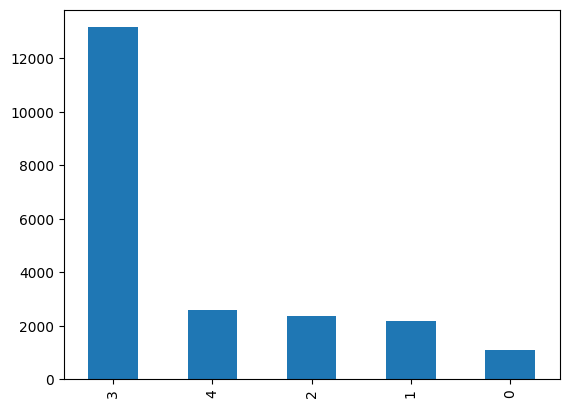

In [51]:
train_path = os.path.join(config.base_input_path, "train.csv")
train_img_dir_path = os.path.join(config.base_input_path, "train_images")
train_df = pd.read_csv(train_path)
train_df.label.value_counts().plot(kind="bar")

In [52]:
from typing import Optional
from torch.utils.data import Dataset
import torch.nn as nn
from torchvision.transforms import transforms

class CassavaDataset(Dataset):
    def __init__(self, annotation_path: Optional[str], img_dir_path: str, img_transforms: transforms.Compose):
        self.has_label = annotation_path is not None
        if annotation_path:
            self.annotation_path = annotation_path
            self.annotation_data = pd.read_csv(annotation_path)
        else:
            self.annotation_path = None
            self.annotation_data = pd.DataFrame()
            self.annotation_data["image_id"] = list(os.listdir(img_dir_path))
        self.img_dir_path = img_dir_path
        self.img_transforms = img_transforms
        
    def __len__(self) -> int:
        return len(self.annotation_data)
    
    def __getitem__(self, index: int):
        data = self.annotation_data.iloc[index, :]
        image_id = data["image_id"]
        if self.has_label:
            label = data["label"]
        image_path = os.path.join(self.img_dir_path, image_id)        
        img = Image.open(image_path).convert("RGB")
        if self.img_transforms:
            img = self.img_transforms(img)
        if self.has_label:
            label = torch.nn.functional.one_hot(torch.tensor([label]), num_classes=5)
            label = torch.squeeze(label, dim=0).float()
        if self.has_label:
            return img, image_id, label
        else:
            return img, image_id

## Network

In [53]:
import timm


class CassavaNetwork(nn.Module):
    def __init__(self, config: Config, output_dim: int = 5):
        super().__init__()
        self.base_model = timm.create_model(
            config.model_name,
            pretrained=not config.is_kaggle_notebook,
            num_classes=output_dim,
        )
    
    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return self.base_model(img)
    

model = CassavaNetwork(config=config)

## Trainer

In [54]:
from modules.trainer import Trainer

## Classifier

In [55]:
from modules.classifier import Classifier, ClassifierTrainInput, ClassifierTestInput, ClassifierOutput

## Run

<AxesSubplot: >

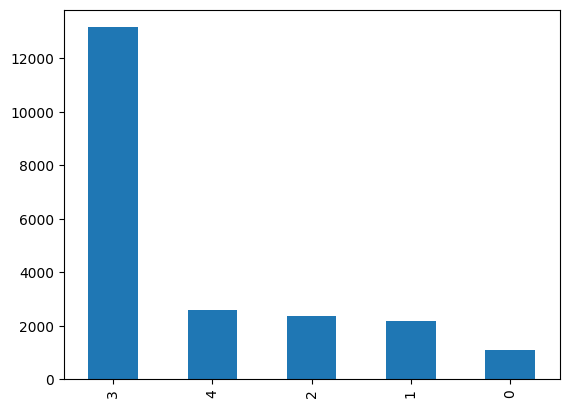

In [56]:
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

index = 3
name = f"run-{index}"
notes = ""

train_path = os.path.join(config.base_input_path, "train.csv")
train_img_dir_path = os.path.join(config.base_input_path, "train_images")
df = pd.read_csv(train_path)

df.label.value_counts().plot(kind="bar")

In [57]:
from modules.set_seed import set_seed

set_seed(42)

RandomState(MT19937) at 0x7F10FABFFB40

In [58]:
k_fold = KFold(n_splits=2)
train_dataset = CassavaDataset(
    annotation_path=train_path,
    img_dir_path=train_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),    
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize((224, 224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)
val_dataset = CassavaDataset(
    annotation_path=train_path,
    img_dir_path=train_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
    ]),
)

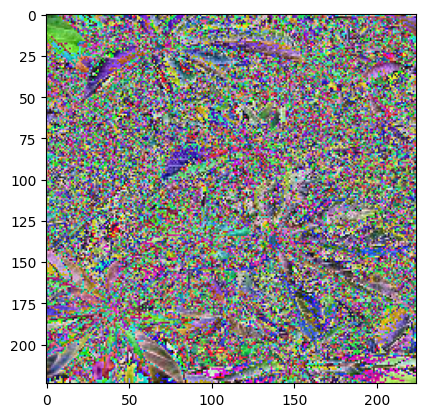

In [59]:
import matplotlib.pyplot as plt

img = train_dataset[10][0]
plt.imshow(transforms.ToPILImage()(img))

In [60]:
from torch.cuda.amp.grad_scaler import GradScaler

for fold, (train_index, val_index) in enumerate(k_fold.split(df)):
    train_subset = Subset(train_dataset, train_index)
    train_dataloader = DataLoader(
        train_subset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        shuffle=True,
    )
    val_subset = Subset(val_dataset, val_index)
    val_dataloader = DataLoader(
        val_subset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        shuffle=False,
    )
    model = CassavaNetwork(config=config)
    model = model.to(torch.device("cuda"))
    model = nn.DataParallel(model)

    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    loss_function = nn.CrossEntropyLoss()

    activate_function = nn.Softmax(dim=1)
    
    scaler = GradScaler()

    trainer = Trainer(
        model,
        config,
        optimizer,
        scheduler,
        loss_function,
        train_dataloader,
        scaler=scaler,
    )
    classifier = Classifier(
        model,
        activate_function,
        train_dataloader,
        phase="train",
        phase_input=ClassifierTrainInput(),
    )

    val_classifier = Classifier(
        model,
        activate_function,
        val_dataloader,
        phase="test",
        phase_input=ClassifierTestInput(),
    )


    for epoch in tqdm(range(config.n_epochs)):
        epoch += 1
        train_out = trainer.advance()
        print(f"epoch: {epoch}, train loss: {train_out.loss}")
        train_infer_out = classifier.infer()
        print(f"epoch: {epoch}, train acc: {train_infer_out.acc}")
        val_infer_out = val_classifier.infer()
        print(f"epoch: {epoch}, val acc: {val_infer_out.acc}")
        if epoch == config.n_epochs:
            trainer.save_model()
    break

# Create submissions


  0%|          | 0/10 [00:00<?, ?it/s]

## Submission

In [ ]:
test_data_img_dir_path = os.path.join(config.base_input_path, "test_images")
test_dataset = CassavaDataset(
    annotation_path=None,
    img_dir_path=test_data_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
)

test_classifier = Classifier(
    model,
    activate_function,
    test_dataloader,
    phase="test",
    phase_input=ClassifierTrainInput(),
)

out = test_classifier.infer(calc_acc=False, verbose=True)
out.df.to_csv("submission.csv", index=False)